In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

%matplotlib inline

curr_dir = os.getcwd()

In [29]:
data = np.load('mfcc_data_normalized.npy', allow_pickle=True)

In [30]:
data.shape

(474, 3)

In [31]:
# Convert back to float32
for i in range(data.shape[0]):
    data[i][0] = data[i][0].astype('float32')

In [32]:
time_lengths = [data[i][2] for i in range(data.shape[0])]

In [33]:
time_lengths = np.asarray(time_lengths)

In [34]:
np.min(time_lengths)

562

In [35]:
labels = list(pd.value_counts(data[:,1]).axes[0])
#labels = list(set([data[i][1] for i in range(data.shape[0])]))
labels

['Thryothorus ludovicianus',
 'Vireo griseus',
 'Baeolophus atricristatus',
 'Pitangus sulphuratus',
 'Mimus polyglottos',
 'Passerina ciris',
 'Poecile carolinensis',
 'Catherpes mexicanus',
 'Vireo atricapilla',
 'Toxostoma longirostre',
 'Spiza americana',
 'Rallus elegans',
 'Thryomanes bewickii',
 'Myiarchus cinerascens',
 'Aphelocoma wollweberi',
 'Cardinalis cardinalis',
 'Tyrannus forficatus',
 'Setophaga chrysoparia',
 'Piranga rubra',
 'Leiothlypis crissalis',
 'Melanerpes aurifrons',
 'Setophaga dominica',
 'Sturnella magna',
 'Peucaea cassinii',
 'Cyanocorax luxuosus',
 'Melanerpes erythrocephalus',
 'Vireo bellii',
 'Cyanocitta cristata',
 'Numenius americanus',
 'Arremonops rufivirgatus',
 'Spizella atrogularis',
 'Tympanuchus pallidicinctus',
 'Turdus grayi',
 'Tyrannus couchii',
 'Setophaga citrina',
 'Icteria virens',
 'Glaucidium brasilianum',
 'Geothlypis trichas',
 'Passerina amoena',
 'Peucaea aestivalis',
 'Setophaga pitiayumi',
 'Quiscalus mexicanus',
 'Polioptil

In [36]:
# 45 classes
len(labels)

45

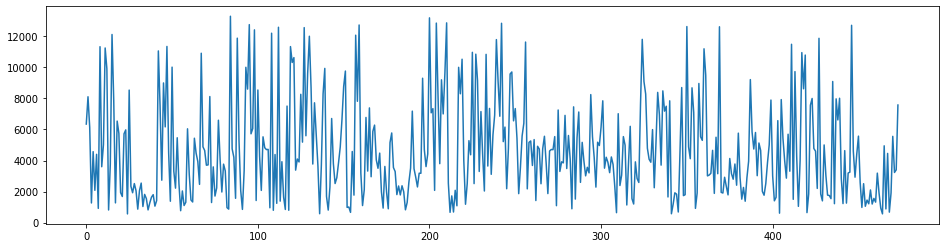

In [162]:
plt.figure(figsize=(16,4))
plt.plot(time_lengths)

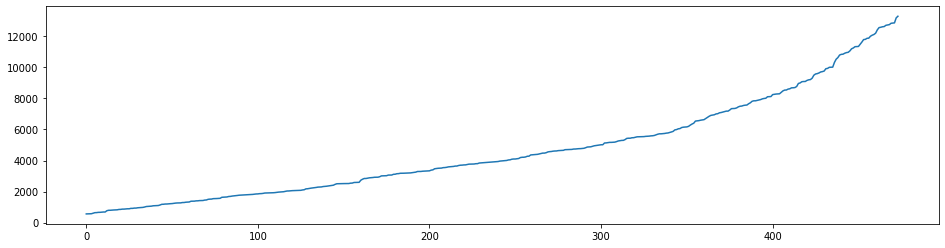

In [163]:
plt.figure(figsize=(16,4))
plt.plot(sorted(time_lengths))

In [37]:
model = tf.keras.Sequential()
model.add(layers.LSTM(128, input_shape=(500, 18)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(45, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               75264     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 45)                11565     
Total params: 119,853
Trainable params: 119,853
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [103]:
# Testing holdout data must be randomly shuffled around the training set, 
# otherwise you'll be testing on out-of-distribution data
# 80 - 10 - 10 | train - validation - test 
train_sample_indices = np.random.choice([x for x in range(data.shape[0])], 
                                        int(0.8*data.shape[0]), replace=False)
print(train_sample_indices)
validation_sample_indices = np.random.choice(list(set([x for x in range(data.shape[0])]) - set(train_sample_indices)), 
                                       int(0.1*data.shape[0]), replace=False)
print(validation_sample_indices)
test_sample_indices = list(set([x for x in range(data.shape[0])]) - set(train_sample_indices) - set(validation_sample_indices))
print(test_sample_indices)
print(len(train_sample_indices), 
      len(validation_sample_indices),
      len(test_sample_indices), 
      len(train_sample_indices)+len(validation_sample_indices)+len(test_sample_indices))

[275 406 151  61  82  87 137 323  38  54 451 179 277  21 158  65 168 113
 220 213  98 336 351 107 173 354 319 241 382 339  99 317 402 416  34 298
 384 412 463 156 274  70 184 386 114 314 453 468 140 375 303  72 350 357
 284 466 210 191 460 315 232  91 257 157 455 108 452 123 426 190 204 149
 112 430 254 193 449 162 177 454 181 104 144 380 183  15 159  17 313 180
 152 276 117 305   0 211 332 405 401 200 178 471  39 458 404 233  50 340
  92 301 306 374 239 296 143 417  31 322 138 109 370 364 308 388 187 428
 265 198 236  25 400 230 110 371 431 188  18   4 316 292 132  55 278 268
 120 228 394 448  95 286  88 442 310  78 171  94  56 312 235  48 462 167
 155 279 264 222 240  32 447 389  76 287 199  53 249 348 390  93 166 325
  29 439 103 101 359 421 438 362 121 385 299 118 126 115 422  69   2 307
 472 343 341  27 461  67 282  58 131 288 169 209 105 170 311 297 352 201
 425 435  46 252 379 269   9 273 221   5 391 342 450  77 420  79  11  23
 261 270 194  16 368 326 294 411 464 392 349 271  4

In [104]:
def train_generator():
    # Number of training examples per step
    samples = len(train_sample_indices) # Full set, but not all time samples within it
    steps = 500
    while True:
        # Sample a set of training indices
        train_inds = train_sample_indices #np.random.choice(train_sample_indices, samples, replace=False)
        # Then for each one sample a segment...
        train_start_times = [np.random.randint(0, time_lengths[train_inds[i]]-steps) for i in range(samples)]
        # Then select that part of the feature data and labels
        x_train = np.asarray([data[train_inds[i],0][train_start_times[i]:(train_start_times[i]+steps),:] for i in range(samples)])
        y_train = np.asarray([labels.index(data[train_inds[i],1]) for i in range(samples)])
        yield x_train, y_train

def validation_generator():
    # Number of validation examples per step
    samples = len(validation_sample_indices) # Full set, but not all time samples within it
    steps = 500
    while True:
        # Sample a set of training indices
        validation_inds = validation_sample_indices #np.random.choice(validation_sample_indices, samples, replace=False)
        # Then for each one sample a segment...
        validation_start_times = [np.random.randint(0, time_lengths[validation_inds[i]]-steps) for i in range(samples)]
        # Then select that part of the feature data and labels
        x_validation = np.asarray([data[validation_inds[i],0][validation_start_times[i]:(validation_start_times[i]+steps),:] for i in range(samples)])
        y_validation = np.asarray([labels.index(data[validation_inds[i],1]) for i in range(samples)])
        yield x_validation, y_validation

def test_generator():
    # Number of testing examples per step
    samples = len(test_sample_indices) # Full set, but not all time samples within it
    steps = 500
    while True:
        # Sample a set of training indices
        test_inds = test_sample_indices #np.random.choice(test_sample_indices, samples, replace=False)
        # Then for each one sample a segment...
        test_start_times = [np.random.randint(0, time_lengths[test_inds[i]]-steps) for i in range(samples)]
        # Then select that part of the feature data and labels
        x_test = np.asarray([data[test_inds[i],0][test_start_times[i]:(test_start_times[i]+steps),:] for i in range(samples)])
        y_test = np.asarray([labels.index(data[test_inds[i],1]) for i in range(samples)])
        yield x_test, y_test

In [58]:
es = [callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=3)]

In [105]:
history = model.fit(train_generator(), validation_data=validation_generator(), 
                    steps_per_epoch=100, epochs=20, validation_steps=50,
                   callbacks=None) #es

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 18s 178ms/step - loss: 3.5577 - accuracy: 0.0904 - val_loss: 3.4739 - val_accuracy: 0.0979
Epoch 2/20
100/100 [==============================] - 16s 164ms/step - loss: 3.1523 - accuracy: 0.1705 - val_loss: 3.4668 - val_accuracy: 0.1136
Epoch 3/20
100/100 [==============================] - 16s 162ms/step - loss: 2.9549 - accuracy: 0.2134 - val_loss: 3.3563 - val_accuracy: 0.1243
Epoch 4/20
100/100 [==============================] - 16s 161ms/step - loss: 3.0066 - accuracy: 0.2146 - val_loss: 3.2348 - val_accuracy: 0.1255
Epoch 5/20
100/100 [==============================] - 16s 163ms/step - loss: 2.8340 - accuracy: 0.2441 - val_loss: 3.2748 - val_accuracy: 0.1464
Epoch 6/20
100/100 [==============================] - 16s 162ms/step - loss: 3.1931 - accuracy: 0.1728 - val_loss: 3.5004 - val_accuracy: 0.0753
Epoch 7/20
100/100 [=================

In [106]:
model.evaluate(test_generator(), steps=100)

  ...
    to  
  ['...']
100/100 [==============================] - 2s 17ms/step - loss: 3.4740 - accuracy: 0.1456


[3.4740433502197265, 0.145625]

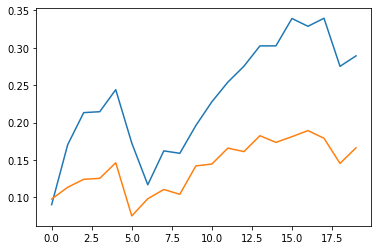

In [107]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['loss'])
# Best test accuracy I've gotten so far was around 30%, but most runs are less than that.
# I think it depends a lot on which files end up being in the test set...

In [3]:
# Spectrogram?
spec_data = np.load("spec_data.npy", allow_pickle=True)
# Convert back to float32
for i in range(spec_data.shape[0]):
    spec_data[i][0] = spec_data[i][0].astype('float32')
spec_time_lengths = [spec_data[i][2] for i in range(spec_data.shape[0])]
spec_time_lengths = np.asarray(spec_time_lengths)
print(np.min(spec_time_lengths))
spec_labels = list(pd.value_counts(spec_data[:,1]).axes[0])
#labels = list(set([data[i][1] for i in range(data.shape[0])]))
print(spec_labels)
len(spec_labels)

In [35]:
smodel = tf.keras.Sequential() # 500 x 200
smodel.add(layers.LSTM(64, input_shape=(500, 200)))
smodel.add(layers.Dense(256, activation='relu'))
smodel.add(layers.Dropout(0.5))
smodel.add(layers.Dense(45, activation='softmax'))

In [36]:
smodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
smodel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 45)                11565     
Total params: 96,045
Trainable params: 96,045
Non-trainable params: 0
_________________________________________________________________


In [107]:
# Testing holdout data must be randomly shuffled around the training set, 
# otherwise you'll be testing on out-of-distribution data
# 80 - 10 - 10 | train - validation - test 
# No difference between validation and test in this case...
train_sample_indices = np.random.choice([x for x in range(spec_data.shape[0])], 
                                        int(0.9*spec_data.shape[0]), replace=False)
print(train_sample_indices)
validation_sample_indices = np.random.choice(list(set([x for x in range(spec_data.shape[0])]) - set(train_sample_indices)), 
                                       int(0.1*spec_data.shape[0]), replace=False)
print(validation_sample_indices)
test_sample_indices = list(set([x for x in range(spec_data.shape[0])]) - set(train_sample_indices) - set(validation_sample_indices))
print(test_sample_indices)
print(len(train_sample_indices), 
      len(validation_sample_indices),
      len(test_sample_indices), 
      len(train_sample_indices)+len(validation_sample_indices)+len(test_sample_indices))

# Used to refer to what was generated
last_label = -1

def spec_train_generator(samples=len(train_sample_indices)):
    global last_label
    # Number of training examples per step
    #samples = len(train_sample_indices)
    steps = 500
    while True:
        # Sample a set of training indices
        train_inds = train_sample_indices #np.random.choice(train_sample_indices, samples, replace=False)
        # Then for each one sample a segment...
        train_start_times = [np.random.randint(0, spec_time_lengths[train_inds[i]]-steps) for i in range(samples)]
        # Then select that part of the feature data and labels
        x_train = np.asarray([spec_data[train_inds[i],0][train_start_times[i]:(train_start_times[i]+steps),:] for i in range(samples)])#.reshape(samples, steps, 200, 1)
        y_train = np.asarray([spec_labels.index(spec_data[train_inds[i],1]) for i in range(samples)])
        last_label = y_train[-1]
        yield x_train, y_train

def spec_validation_generator(samples=len(validation_sample_indices)):
    global last_label
    # Number of validation examples per step
    #samples = len(validation_sample_indices)
    steps = 500
    while True:
        # Sample a set of training indices
        validation_inds = validation_sample_indices #np.random.choice(validation_sample_indices, samples, replace=False)
        # Then for each one sample a segment...
        validation_start_times = [np.random.randint(0, spec_time_lengths[validation_inds[i]]-steps) for i in range(samples)]
        # Then select that part of the feature data and labels
        x_validation = np.asarray([spec_data[validation_inds[i],0][validation_start_times[i]:(validation_start_times[i]+steps),:] for i in range(samples)])#.reshape(samples, steps, 200, 1)
        y_validation = np.asarray([spec_labels.index(spec_data[validation_inds[i],1]) for i in range(samples)])
        last_label = y_validation[-1]
        yield x_validation, y_validation

def spec_test_generator(samples=len(test_sample_indices)):
    global last_label
    # Number of testing examples per step
    #samples = len(test_sample_indices)
    steps = 500
    while True:
        # Sample a set of training indices
        test_inds = test_sample_indices #np.random.choice(test_sample_indices, samples, replace=False)
        # Then for each one sample a segment...
        test_start_times = [np.random.randint(0, spec_time_lengths[test_inds[i]]-steps) for i in range(samples)]
        # Then select that part of the feature data and labels
        x_test = np.asarray([spec_data[test_inds[i],0][test_start_times[i]:(test_start_times[i]+steps),:] for i in range(samples)])#.reshape(samples, steps, 200, 1)
        y_test = np.asarray([spec_labels.index(spec_data[test_inds[i],1]) for i in range(samples)])
        last_label = y_test[-1]
        yield x_test, y_test

# I could write one function with some parameters to handle all of these generators...

[269  36 157 147 143   8 152 344 160 193 121 298 289 347  46 151 125 203
 468 401  85  95 114 411   3  89 259 255 127  64 362 467 343 139  10 296
 299  92 469 328 429 156 439 396 239  62 190 311 100 238 137  83 320 260
 266 430 275 422 440 438 348 291 272 208 426 322  17 443  40 234 377 268
 211 466 158  35 226  66 398 128 273  31 400 389 247  91 150 425  86 285
 315 250 360  32 110 352 148 264  56  22 206 120 217 218 301 165 306 113
 369 314 117 205  50 451 153 180 436  81 257 406  11  69 169  71 305 394
 126 214 446 303 189 386 420  80 375 243 376 232  75 441 124   9 196 215
 233 324 319 458 356 197 339 295  67 202 317  90  33 274  42   5 350 292
 249 161 261 449   6  44  51 412 391 119 408 286  47 384  43 337 252 382
 207 367 198  70 473 325 459 283 359 464 457  88 154 442 424 361 168  15
  76  53  59 365 461  74 407 342 112 276 380 256 130 404  73 279  96  72
  25 374 194 173 432 385 105 103 159 414 393 231  16 155 101   0 213 144
  27 212 294 204 304 177  93 387  97 403 164 471 43

In [38]:
history = smodel.fit(spec_train_generator(), validation_data=spec_validation_generator(), 
                    steps_per_epoch=300, epochs=20, validation_steps=100,
                   callbacks=None)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 300 steps, validate for 100 steps
Epoch 1/20
300/300 [==============================] - 58s 192ms/step - loss: 3.3775 - accuracy: 0.1179 - val_loss: 3.2752 - val_accuracy: 0.1085
Epoch 2/20
300/300 [==============================] - 56s 187ms/step - loss: 3.0389 - accuracy: 0.1869 - val_loss: 3.2735 - val_accuracy: 0.1115
Epoch 3/20
300/300 [==============================] - 56s 187ms/step - loss: 2.7310 - accuracy: 0.2551 - val_loss: 3.2330 - val_accuracy: 0.1564
Epoch 4/20
300/300 [==============================] - 56s 187ms/step - loss: 2.4821 - accuracy: 0.3082 - val_loss: 3.3613 - val_accuracy: 0.1589
Epoch 5/20
300/300 [==============================] - 56s 187ms/step - loss: 2.4309 - accuracy: 0.3277 - val_loss: 3.2751 - val_accuracy: 0.1238
Epoch 6/20
300/300 [==============================] - 56s 187ms/step - loss: 2.3287 - accuracy: 0.3465 - val_loss: 3.2283 - val_accuracy: 0.1640
Epoch 7/20
300/300 [================

In [40]:
smodel.evaluate(spec_validation_generator(), steps=500)

  ...
    to  
  ['...']
500/500 [==============================] - 9s 19ms/step - loss: 4.4081 - accuracy: 0.2426


[4.4081400766372685, 0.24255319]

In [47]:
acclist = []
valacclist = []
losslist = []
vallosslist = []

In [48]:
acclist.extend(history.history['accuracy'])
valacclist.extend(history.history['val_accuracy'])
losslist.extend(history.history['loss'])
vallosslist.extend(history.history['val_loss'])

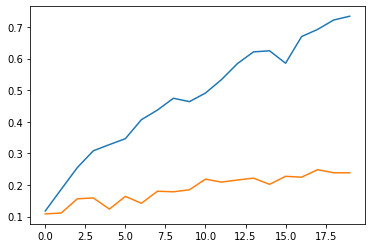

In [49]:
plt.plot(acclist)
plt.plot(valacclist)

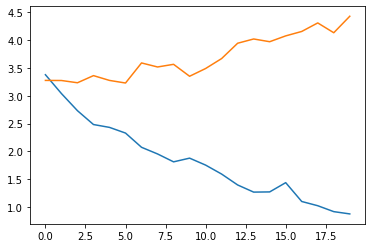

In [50]:
plt.plot(losslist)
plt.plot(vallosslist)

In [39]:
# Reworking this...
# 75 - 25 split
train_sample_indices = np.random.choice([x for x in range(data.shape[0])], 
                                        int(0.75*data.shape[0]), replace=False)
#print(train_sample_indices)
validation_sample_indices = np.random.choice(list(set([x for x in range(data.shape[0])]) - set(train_sample_indices)), 
                                       int(0.25*data.shape[0]), replace=False)
#print(validation_sample_indices)

In [40]:
# Puts together all the generators from before
def data_generator(data, labels, indices, data_lengths, steps=500, samples=None, to_4d=False):
    # Number of testing examples per step
    total_data_length = sum([data_lengths[indices[i]] for i in range(len(indices))])
    if samples is None:
        samples = len(indices)
    #steps = 500
    while True:
        # Sample a set of training indices
        # With probability given by the proportion of time each recording takes in the total time
        # This samples the periods of time uniformly, as if all recordings were back-to-back
        inds = np.random.choice(indices, samples, replace=True, 
                                p=[data_lengths[indices[i]]/total_data_length for i in range(len(indices))])
        # Then for each one sample a segment uniformly
        start_times = [np.random.randint(0, data_lengths[inds[i]]-steps) for i in range(samples)]
        # Then select that part of the feature data and labels
        x = np.asarray([data[inds[i],0][start_times[i]:(start_times[i]+steps),:] for i in range(samples)])
        if to_4d:
            x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
        y = np.asarray([labels.index(data[inds[i],1]) for i in range(samples)])
        yield x, y

In [42]:
full_generator = data_generator(data, labels, [i for i in range(data.shape[0])], time_lengths, steps=100, samples=1000)
train_generator = data_generator(data, labels, train_sample_indices, time_lengths, steps=100, samples=1000)
validation_generator = data_generator(data, labels, validation_sample_indices, time_lengths, steps=100, samples=1000)

In [43]:
model = tf.keras.Sequential()
model.add(layers.LSTM(128, input_shape=(100,18)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(45, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128)               75264     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 45)                11565     
Total params: 119,853
Trainable params: 119,853
Non-trainable params: 0
_________________________________________________________________


In [301]:
es = [callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=20)]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 5 steps
Epoch 1/100
5/5 [==============================] - 2s 367ms/step - loss: 3.7840 - accuracy: 0.0498 - val_loss: 3.8010 - val_accuracy: 0.0576
Epoch 2/100
5/5 [==============================] - 1s 113ms/step - loss: 3.7188 - accuracy: 0.0840 - val_loss: 3.7802 - val_accuracy: 0.0914
Epoch 3/100
5/5 [==============================] - 1s 112ms/step - loss: 3.6169 - accuracy: 0.0722 - val_loss: 3.7793 - val_accuracy: 0.0918
Epoch 4/100
5/5 [==============================] - 1s 111ms/step - loss: 3.5077 - accuracy: 0.0920 - val_loss: 3.8581 - val_accuracy: 0.0818
Epoch 5/100
5/5 [==============================] - 1s 111ms/step - loss: 3.4115 - accuracy: 0.1014 - val_loss: 3.8746 - val_accuracy: 0.0868
Epoch 6/100
5/5 [==============================] - 1s 114ms/step - loss: 3.2845 - accuracy: 0.1200 - val_loss: 3.9294 - val_accuracy: 0.0630
Epoch 7/100
5/5 [==============================] - 1s 114ms/step

5/5 [==============================] - 1s 112ms/step - loss: 1.2941 - accuracy: 0.6462 - val_loss: 4.8448 - val_accuracy: 0.1286
Epoch 58/100
5/5 [==============================] - 1s 112ms/step - loss: 1.2646 - accuracy: 0.6448 - val_loss: 5.0199 - val_accuracy: 0.1368
Epoch 59/100
5/5 [==============================] - 1s 111ms/step - loss: 1.2797 - accuracy: 0.6546 - val_loss: 4.9384 - val_accuracy: 0.1330
Epoch 60/100
5/5 [==============================] - 1s 112ms/step - loss: 1.2424 - accuracy: 0.6536 - val_loss: 5.0323 - val_accuracy: 0.1372
Epoch 61/100
5/5 [==============================] - 1s 111ms/step - loss: 1.1896 - accuracy: 0.6738 - val_loss: 5.1546 - val_accuracy: 0.1220
Epoch 62/100
5/5 [==============================] - 1s 111ms/step - loss: 1.1986 - accuracy: 0.6634 - val_loss: 5.0856 - val_accuracy: 0.1432
Epoch 63/100
5/5 [==============================] - 1s 114ms/step - loss: 1.1408 - accuracy: 0.6834 - val_loss: 5.1040 - val_accuracy: 0.1302
Epoch 64/100
5/5 [=

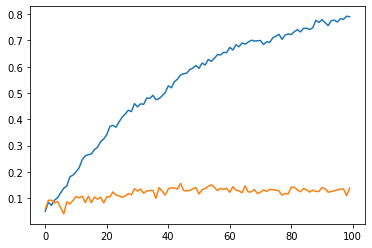

In [44]:
history = model.fit(train_generator, validation_data=validation_generator,
         steps_per_epoch=5, epochs=100, validation_steps=5, callbacks=None)
model.evaluate(validation_generator, steps=10)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

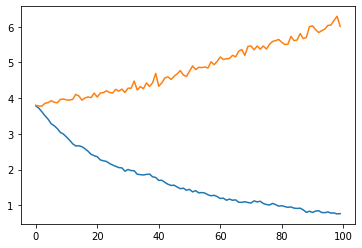

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [313]:
# Attempt to render a confusion matrix by random sampling
confusion_matrix = np.zeros((len(spec_labels), len(spec_labels)))
print(confusion_matrix.shape)

(45, 45)


In [185]:
# To do: 
# Create a uniform random sample from the total times rather than a uniform sample across files
# Create a stratified random sample for the validation set so that the classes are more balanced.

In [314]:
for _ in range(500):
    pred_data = validation_generator.__next__()
    pred = model.predict(pred_data[0], steps=1)
    for i in range(pred.shape[0]):
        predval = np.argmax(pred[i,:])
        actual = pred_data[1][i]
        confusion_matrix[actual,predval] += 1

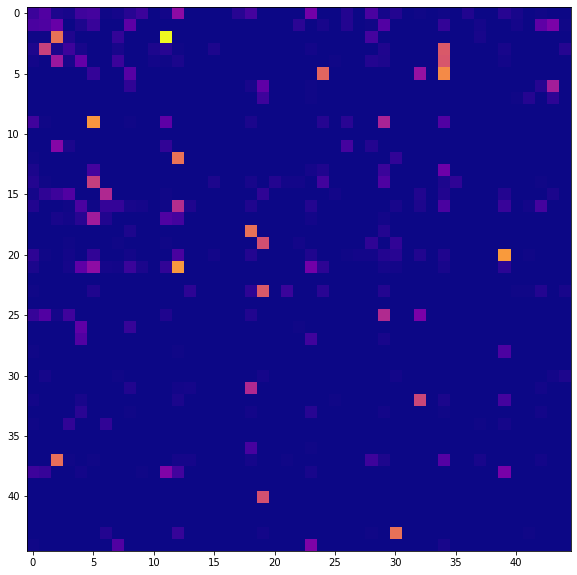

In [315]:
plt.figure(figsize=(10,10))
plt.imshow(confusion_matrix, cmap='plasma')

In [325]:
# How well-stratified is the validation set?
vc_train = pd.value_counts([data[train_sample_indices[i],1] for i in range(len(train_sample_indices))])
print(vc_train)
print(len(vc_train))
vc_validation = pd.value_counts([data[validation_sample_indices[i],1] for i in range(len(validation_sample_indices))])
print(vc_validation)
print(len(vc_validation))

Vireo griseus                 19
Thryothorus ludovicianus      15
Baeolophus atricristatus      14
Poecile carolinensis          14
Pitangus sulphuratus          14
Passerina ciris               13
Vireo atricapilla             13
Catherpes mexicanus           11
Mimus polyglottos             11
Rallus elegans                10
Toxostoma longirostre         10
Setophaga chrysoparia         10
Piranga rubra                  9
Setophaga dominica             9
Spiza americana                9
Thryomanes bewickii            9
Aphelocoma wollweberi          8
Myiarchus cinerascens          7
Vireo bellii                   7
Cardinalis cardinalis          7
Melanerpes aurifrons           7
Spizella atrogularis           7
Peucaea cassinii               7
Tyrannus forficatus            7
Melanerpes erythrocephalus     7
Cyanocitta cristata            7
Sturnella magna                7
Numenius americanus            7
Setophaga citrina              6
Arremonops rufivirgatus        6
Leiothlypi

In [278]:
# The training data contains all classes, but the test data is missing some classes...
# I should probably use stratified sampling to pick the validation indices.

In [3]:
# Spectrogram?
spec_data = np.load("spec_data_normalized.npy", allow_pickle=True)
# Convert back to float32
for i in range(spec_data.shape[0]):
    spec_data[i][0] = spec_data[i][0].astype('float32')
spec_time_lengths = [spec_data[i][2] for i in range(spec_data.shape[0])]
spec_time_lengths = np.asarray(spec_time_lengths)
print(np.min(spec_time_lengths))
spec_labels = list(pd.value_counts(spec_data[:,1]).axes[0])
#labels = list(set([data[i][1] for i in range(data.shape[0])]))
print(spec_labels)
len(spec_labels)

597
['Thryothorus ludovicianus', 'Vireo griseus', 'Baeolophus atricristatus', 'Pitangus sulphuratus', 'Mimus polyglottos', 'Passerina ciris', 'Poecile carolinensis', 'Catherpes mexicanus', 'Vireo atricapilla', 'Toxostoma longirostre', 'Spiza americana', 'Rallus elegans', 'Thryomanes bewickii', 'Myiarchus cinerascens', 'Aphelocoma wollweberi', 'Cardinalis cardinalis', 'Tyrannus forficatus', 'Setophaga chrysoparia', 'Piranga rubra', 'Leiothlypis crissalis', 'Melanerpes aurifrons', 'Setophaga dominica', 'Sturnella magna', 'Peucaea cassinii', 'Cyanocorax luxuosus', 'Melanerpes erythrocephalus', 'Vireo bellii', 'Cyanocitta cristata', 'Numenius americanus', 'Arremonops rufivirgatus', 'Spizella atrogularis', 'Tympanuchus pallidicinctus', 'Turdus grayi', 'Tyrannus couchii', 'Setophaga citrina', 'Icteria virens', 'Glaucidium brasilianum', 'Geothlypis trichas', 'Passerina amoena', 'Peucaea aestivalis', 'Setophaga pitiayumi', 'Quiscalus mexicanus', 'Polioptila caerulea', 'Aimophila ruficeps', 'Ag

45

In [20]:
# Reworking this...
# 75 - 25 split
train_sample_indices = np.random.choice([x for x in range(spec_data.shape[0])], 
                                        int(0.75*spec_data.shape[0]), replace=False)
#print(train_sample_indices)
validation_sample_indices = np.random.choice(list(set([x for x in range(spec_data.shape[0])]) - set(train_sample_indices)), 
                                       int(0.25*spec_data.shape[0]), replace=False)
#print(validation_sample_indices)

In [21]:
full_generator = data_generator(spec_data, spec_labels, [i for i in range(spec_data.shape[0])], spec_time_lengths, steps=100, samples=200)
train_generator = data_generator(spec_data, spec_labels, train_sample_indices, spec_time_lengths, steps=100, samples=200)
validation_generator = data_generator(spec_data, spec_labels, validation_sample_indices, spec_time_lengths, steps=100, samples=200)

In [22]:
smodel = tf.keras.Sequential()
smodel.add(layers.LSTM(128, input_shape=(100,200)))
#smodel.add(layers.Dropout(0.25))
smodel.add(layers.Dense(128))
#smodel.add(layers.Dropout(0.5))
smodel.add(layers.Dense(45, activation='softmax'))
smodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
smodel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 45)                5805      
Total params: 190,765
Trainable params: 190,765
Non-trainable params: 0
_________________________________________________________________


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 5 steps
Epoch 1/100
5/5 [==============================] - 0s 61ms/step - loss: 0.6504 - accuracy: 0.7940 - val_loss: 5.7326 - val_accuracy: 0.1280
Epoch 2/100
5/5 [==============================] - 0s 63ms/step - loss: 0.5960 - accuracy: 0.8130 - val_loss: 5.9983 - val_accuracy: 0.1430
Epoch 3/100
5/5 [==============================] - 0s 65ms/step - loss: 0.6804 - accuracy: 0.7930 - val_loss: 5.8883 - val_accuracy: 0.1560
Epoch 4/100
5/5 [==============================] - 0s 61ms/step - loss: 0.6064 - accuracy: 0.8300 - val_loss: 5.8049 - val_accuracy: 0.1350
Epoch 5/100
5/5 [==============================] - 0s 62ms/step - loss: 0.5546 - accuracy: 0.8360 - val_loss: 6.0205 - val_accuracy: 0.1490
Epoch 6/100
5/5 [==============================] - 0s 60ms/step - loss: 0.5029 - accuracy: 0.8450 - val_loss: 6.2557 - val_accuracy: 0.1320
Epoch 7/100
5/5 [==============================] - 0s 60ms/step - loss

Epoch 58/100
5/5 [==============================] - 0s 67ms/step - loss: 0.5555 - accuracy: 0.8400 - val_loss: 6.1010 - val_accuracy: 0.1510
Epoch 59/100
5/5 [==============================] - 0s 61ms/step - loss: 0.5818 - accuracy: 0.8290 - val_loss: 6.3920 - val_accuracy: 0.1470
Epoch 60/100
5/5 [==============================] - 0s 59ms/step - loss: 0.5180 - accuracy: 0.8340 - val_loss: 5.8997 - val_accuracy: 0.1930
Epoch 61/100
5/5 [==============================] - 0s 62ms/step - loss: 0.5510 - accuracy: 0.8340 - val_loss: 6.2187 - val_accuracy: 0.1570
Epoch 62/100
5/5 [==============================] - 0s 66ms/step - loss: 0.5811 - accuracy: 0.8260 - val_loss: 6.2413 - val_accuracy: 0.1600
Epoch 63/100
5/5 [==============================] - 0s 60ms/step - loss: 0.6291 - accuracy: 0.8030 - val_loss: 5.8894 - val_accuracy: 0.1480
Epoch 64/100
5/5 [==============================] - 0s 59ms/step - loss: 0.5078 - accuracy: 0.8600 - val_loss: 6.0603 - val_accuracy: 0.1420
Epoch 65/100


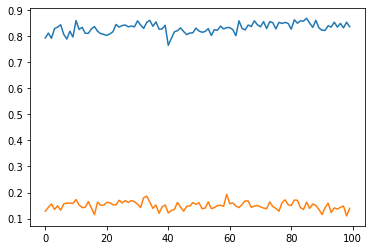

In [28]:
history = smodel.fit(train_generator, validation_data=validation_generator,
         steps_per_epoch=5, epochs=100, validation_steps=5, callbacks=None)
smodel.evaluate(validation_generator, steps=10)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])